In [18]:
import pandas as pd
import numpy as np
from datetime import datetime


price_data = {
    '2021-01-01': 1.50, '2021-11-01': 228.00, '2021-12-16': 180.00,
    '2022-12-31': 10.00, '2023-02-20': 26.00, '2024-10-22': 155.00,
    '2025-01-10': 214.95, '2025-05-27': 178.68
}

dates = pd.to_datetime(list(price_data.keys()))
prices = list(price_data.values())

np.random.seed(42)
random_dates = pd.date_range('2021-01-01', '2025-05-27', freq='D')
random_dates = np.random.choice(random_dates, 2000, replace=True)
random_dates.sort()

date_timestamps = dates.map(pd.Timestamp.timestamp)
random_date_stamps = pd.to_datetime(random_dates)
random_date_ts = random_date_stamps.map(pd.Timestamp.timestamp)

sol_prices = np.interp(random_date_ts, date_timestamps, prices)

range_widths = np.random.choice([0.15, 0.20], size=2000)

lower_bounds = sol_prices * (1 - range_widths)
upper_bounds = sol_prices * (1 + range_widths)

today_price = price_data['2025-05-27']
still_in_range = ((lower_bounds <= today_price) & (today_price <= upper_bounds)).astype(int)

df = pd.DataFrame({
    'DATE': random_date_stamps.strftime('%Y-%m-%d'),
    'LOWER BOUND': np.round(lower_bounds, 2),
    'UPPER BOUND': np.round(upper_bounds, 2),
    'SOL PRICE ON THAT DATE': np.round(sol_prices, 2),
    'STILL ON RANGE BY TODAYS PRICE': still_in_range
})

real_data = [
    ['2021-11-01', 182.40, 273.60, 228.00, 0],
    ['2021-12-16', 144.00, 216.00, 180.00, 1],
    ['2024-10-22', 131.75, 178.25, 155.00, 0]
]
for i, row in enumerate(real_data):
    df.iloc[i] = row

df.to_csv('sol_usdc_pools.csv', index=False)
print(df.head())


         DATE  LOWER BOUND  UPPER BOUND  SOL PRICE ON THAT DATE  \
0  2021-11-01       182.40       273.60                  228.00   
1  2021-12-16       144.00       216.00                  180.00   
2  2024-10-22       131.75       178.25                  155.00   
3  2021-01-02         1.80         2.69                    2.25   
4  2021-01-03         2.54         3.44                    2.99   

   STILL ON RANGE BY TODAYS PRICE  
0                               0  
1                               1  
2                               0  
3                               0  
4                               0  


In [19]:
df = pd.read_csv("sol_usdc_pools.csv")
df

,DATE,LOWER BOUND,UPPER BOUND,SOL PRICE ON THAT DATE,STILL ON RANGE BY TODAYS PRICE
0,2021-11-01,182.40,273.60,228.00,0
1,2021-12-16,144.00,216.00,180.00,1
2,2024-10-22,131.75,178.25,155.00,0
3,2021-01-02,1.80,2.69,2.25,0
4,2021-01-03,2.54,3.44,2.99,0
...,...,...,...,...,...
1995,2025-05-23,143.79,215.69,179.74,1
1996,2025-05-24,143.58,215.37,179.47,1
1997,2025-05-25,143.37,215.05,179.21,1
1998,2025-05-27,142.94,214.42,178.68,1


In [35]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pytensor.tensor as T

O modelo assume que a variável de interesse (neste caso, o preço do SOL) segue uma **distribuição Weibull**, bastante comum em análise de sobrevivência. A Weibull tem dois parâmetros:

- **alpha** (*parâmetro de forma*): controla como o risco do evento muda à medida que o preço aumenta.  
- **beta** (*parâmetro de escala*): define o "ritmo" ou o valor típico onde o evento tende a acontecer.

A função de sobrevivência da Weibull é:

S(x) = e^( - (x / beta)^alpha )

In [32]:
lower = df["LOWER BOUND"].values
upper = df["UPPER BOUND"].values

with pm.Model() as model:
    alpha = pm.HalfNormal("alpha", sigma=2)
    beta = pm.HalfNormal("beta", sigma=200)

    # S(x) = exp(-(x/beta)**alpha)
    # P(event in [l, u]) = S(l) - S(u)
    S_lower = T.exp(-((lower / beta) ** alpha))
    S_upper = T.exp(-((upper / beta) ** alpha))
    p = S_lower - S_upper

    # Probabilidade de estar em [l,u]
    pm.Potential("likelihood", T.sum(T.log(p)))

No PyMC, usamos o comando `pm.Potential` para somar o log dessas probabilidades para cada linha do nosso dataset. O modelo aprende, com base nesses intervalos, os valores mais prováveis para alpha e beta.

**Resumo:**  
Com esse modelo, conseguimos inferir como varia a probabilidade de “sobrevivência” (ou seja, de ainda não ter ocorrido o evento) para qualquer preço de SOL, baseando-nos apenas nos intervalos observados nos dados.

In [33]:
with model:
  trace = pm.sample()

Output()

In [34]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.816,0.034,1.748,1.875,0.001,0.001,1766.0,1187.0,1.0
beta,117.735,1.542,114.655,120.543,0.035,0.034,1890.0,1397.0,1.0


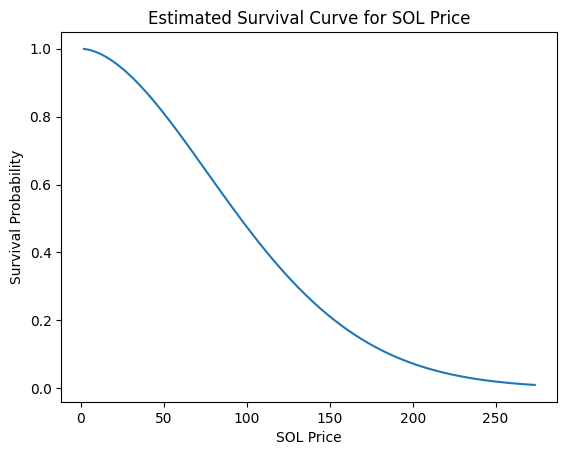

In [36]:
import matplotlib.pyplot as plt

# Get posterior means
alpha_mean = trace.posterior['alpha'].mean().values
beta_mean = trace.posterior['beta'].mean().values

x = np.linspace(df["LOWER BOUND"].min(), df["UPPER BOUND"].max(), 100)
S_x = np.exp(-((x / beta_mean) ** alpha_mean))

plt.plot(x, S_x)
plt.xlabel('SOL Price')
plt.ylabel('Survival Probability')
plt.title('Estimated Survival Curve for SOL Price')
plt.show()

> ## O que esse gráfico de sobrevivência quer dizer?

Esse gráfico mostra a **probabilidade de sobrevivência do preço do SOL** de acordo com o seu modelo Weibull.

- **Eixo X:** Valor do preço do SOL (por exemplo, $50, $100, $150...).
- **Eixo Y:** Probabilidade de sobrevivência. Isso quer dizer:  
  “Qual a chance do evento **ainda NÃO ter acontecido** até esse preço?”

### Como interpretar, linha por linha

- No começo (preço baixo, à esquerda), a curva começa perto de 1.
    - Isso significa que, para preços baixos, quase todo mundo ainda “sobreviveu” (ou seja, o evento não aconteceu).
- Conforme o preço do SOL aumenta, a curva vai caindo.
    - Quanto mais você vai para a direita (preço maior), menor é a chance do evento ainda não ter acontecido.
- Quando chega perto de zero, significa que **quase todos já tiveram o evento** (ou seja, quase ninguém “sobreviveu” até um preço tão alto).

### Exemplificando

- Se você olhar um ponto na curva, por exemplo, no preço 100:
    - Se o valor no eixo Y é 0.4, isso quer dizer que **40% dos casos ainda não tiveram o evento** até o SOL chegar a 100.  
    - Ou seja, 60% já “falharam” antes desse preço.

### Por que a curva cai?

- O modelo está dizendo: “quanto mais alto o preço do SOL, mais provável que o evento já tenha acontecido”.
- Se a curva cair muito rápido, quer dizer que a maioria dos eventos acontece logo (em preços baixos).
- Se cair devagar, significa que é comum sobreviver até preços mais altos.

---

**Resumo final:**  
> Essa curva serve pra você ver, pra qualquer preço do SOL, qual a chance de “ainda estar vivo” (evento não ocorreu). É como perguntar: “Se eu chegar nesse preço, qual a probabilidade de ainda não ter acontecido o que eu estou estudando?”


In [59]:
df['DATE'] = pd.to_datetime(df['DATE'])

df['days_since_start'] = (df['DATE'] - df['DATE'].min()).dt.days

X = df[['days_since_start', 'STILL ON RANGE BY TODAYS PRICE']].values
X = (X - X.mean(axis=0)) / X.std(axis=0)
lower = df['LOWER BOUND'].values
upper = df['UPPER BOUND'].values

> ## O que esse modelo faz? (Versão “explica como se eu fosse burro”)

Esse modelo é uma versão melhorada do modelo de sobrevivência: **agora ele leva em conta “características” (covariáveis) de cada linha** do seu dataset. Ou seja, ele tenta entender se certas coisas (tipo a data ou se ainda está no range) mudam a chance do evento acontecer em um preço mais alto ou mais baixo.

### O que são essas covariáveis?
- `days_since_start`: quantos dias se passaram desde o início da sua série (pra transformar data em número).
- `STILL ON RANGE BY TODAYS PRICE`: se ainda está no range (1) ou não (0) na data daquele registro.

Essas duas colunas viram as **“entradas” do modelo**.

### O que o modelo faz com elas?
1. **Padroniza as covariáveis** (tira a média e divide pelo desvio padrão). Isso ajuda o algoritmo a rodar mais suave, sem números gigantes bagunçando tudo.
2. Para cada linha, ele calcula um valor chamado `beta` usando as covariáveis.  
   A fórmula é assim:


In [55]:
with pm.Model() as model_2:
    alpha = pm.HalfNormal("alpha", sigma=2)
    w = pm.Normal("w", mu=0, sigma=5, shape=X.shape[1])

    beta = pm.Deterministic("beta", T.exp(pm.math.dot(X, w)))

    S_lower = T.exp(-((lower / beta) ** alpha))
    S_upper = T.exp(-((upper / beta) ** alpha))
    p = S_lower - S_upper

    pm.Potential("likelihood", T.sum(T.log(p + 1e-12)))

In [56]:
with model_2:
  trace_2 = pm.sample()

Output()

In [57]:
pm.summary(trace_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.179,0.003,0.174,0.184,0.000,0.000,3409.0,1657.0,1.0
beta[0],0.614,0.089,0.448,0.781,0.002,0.002,3103.0,1482.0,1.0
beta[1],0.614,0.089,0.448,0.781,0.002,0.002,3103.0,1482.0,1.0
beta[2],0.614,0.089,0.448,0.781,0.002,0.002,3103.0,1482.0,1.0
beta[3],0.614,0.089,0.449,0.781,0.002,0.002,3102.0,1482.0,1.0
...,...,...,...,...,...,...,...,...,...
beta[1997],2.631,0.490,1.772,3.604,0.009,0.011,2857.0,1629.0,1.0
beta[1998],2.633,0.491,1.773,3.609,0.009,0.011,2860.0,1629.0,1.0
beta[1999],2.633,0.491,1.773,3.609,0.009,0.011,2860.0,1629.0,1.0
w[0],0.158,0.081,0.002,0.306,0.001,0.002,3057.0,1534.0,1.0


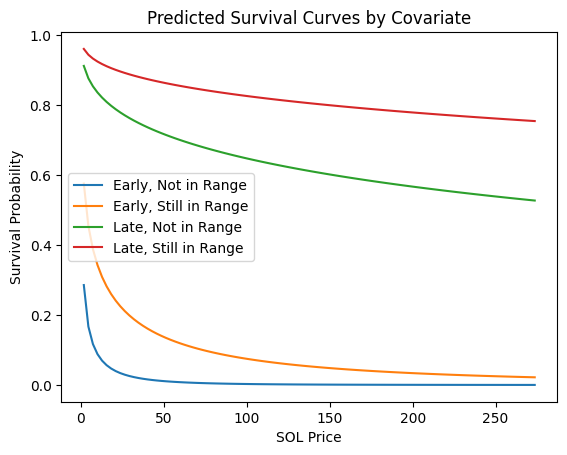

In [58]:
import numpy as np
import matplotlib.pyplot as plt

w0 = np.median(trace.posterior['w'].values[...,0])
w1 = np.median(trace.posterior['w'].values[...,1])
alpha_median = np.median(trace.posterior['alpha'].values)

days_since_start_early = (0 - X[:,0].mean()) / X[:,0].std()   # earliest
days_since_start_late  = (df['days_since_start'].max() - X[:,0].mean()) / X[:,0].std()   # latest
range0 = (0 - X[:,1].mean()) / X[:,1].std()
range1 = (1 - X[:,1].mean()) / X[:,1].std()

def get_beta(ds, sr):
    return np.exp(w0*ds + w1*sr)

x = np.linspace(df["LOWER BOUND"].min(), df["UPPER BOUND"].max(), 100)

beta_early0 = get_beta(days_since_start_early, range0)
beta_early1 = get_beta(days_since_start_early, range1)
beta_late0  = get_beta(days_since_start_late,  range0)
beta_late1  = get_beta(days_since_start_late,  range1)

S_early0 = np.exp(-((x / beta_early0) ** alpha_median))
S_early1 = np.exp(-((x / beta_early1) ** alpha_median))
S_late0  = np.exp(-((x / beta_late0)  ** alpha_median))
S_late1  = np.exp(-((x / beta_late1)  ** alpha_median))

plt.plot(x, S_early0, label="Early, Not in Range")
plt.plot(x, S_early1, label="Early, Still in Range")
plt.plot(x, S_late0, label="Late, Not in Range")
plt.plot(x, S_late1, label="Late, Still in Range")
plt.xlabel("SOL Price")
plt.ylabel("Survival Probability")
plt.title("Predicted Survival Curves by Covariate")
plt.legend()
plt.show()


> ## O que esse gráfico significa?

Aqui temos o gráfico de sobrevivência mostrando como os **efeitos das covariáveis** (data e se ainda está no range) mudam a chance do evento acontecer a diferentes preços do SOL.

### O que são os cenários (“Early”, “Late”, etc.)?

- **Early, Not in Range:**  
  Registro do começo do dataset, e que já saiu do range.
- **Early, Still in Range:**  
  Começo do dataset, mas ainda está no range.
- **Late, Not in Range:**  
  Registro do fim do dataset, mas já saiu do range.
- **Late, Still in Range:**  
  Registro do fim do dataset, e ainda está no range.

### Como o código faz isso?

1. **Pega os pesos (`w0` e `w1`) e o parâmetro `alpha` ajustados pelo modelo.**
2. **Cria exemplos extremos**:
    - `days_since_start_early` → o mais antigo (primeiro dia)
    - `days_since_start_late` → o mais recente (último dia)
    - `range0` → não está no range (valor 0)
    - `range1` → ainda está no range (valor 1)
3. **Calcula `beta` para cada cenário**, combinando os pesos das covariáveis.
4. **Para cada cenário, calcula a curva de sobrevivência Weibull** (chance do evento ainda não ter acontecido até certo preço do SOL).
5. **Plota as quatro curvas**: cada linha mostra um cenário diferente.

### Como interpretar o gráfico?

- **Cada curva mostra, para um grupo específico, a probabilidade de ainda não ter acontecido o evento até cada valor do preço.**
- **Curvas mais altas/para a direita** significam que o grupo tende a "sobreviver" até preços maiores.
- Por exemplo:
    - Se a curva "Late, Still in Range" (normalmente vermelha) está mais pra cima, quer dizer que os eventos desse grupo costumam acontecer em preços mais altos ou demoram mais pra acontecer.
    - Curvas que caem mais rápido (por exemplo, "Early, Not in Range") significam que, pra esses casos, o evento já aconteceu logo nos preços baixos.

---

**Resumo:**  
> O gráfico te mostra, para cada combinação de data e status (“no começo ou no fim da série, já saiu ou ainda está no range”), qual a chance de “ainda não ter acontecido” até cada preço do SOL.  
> Serve pra comparar grupos: quem demora mais pra ter o evento, quem "sobrevive" até preços maiores, etc.



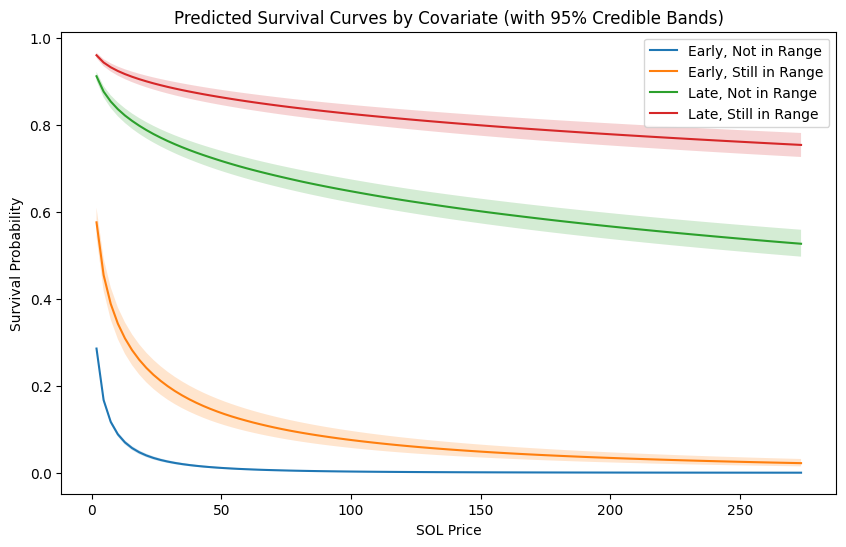

In [60]:
import numpy as np
import matplotlib.pyplot as plt

w_samples = trace.posterior['w'].values.reshape(-1, 2)
alpha_samples = trace.posterior['alpha'].values.flatten()

n_samples = 500
idx = np.random.choice(len(alpha_samples), size=n_samples, replace=False)

days_since_start_early = (0 - X[:,0].mean()) / X[:,0].std()
days_since_start_late  = (df['days_since_start'].max() - X[:,0].mean()) / X[:,0].std()
range0 = (0 - X[:,1].mean()) / X[:,1].std()
range1 = (1 - X[:,1].mean()) / X[:,1].std()

scenarios = [
    (days_since_start_early, range0, "Early, Not in Range"),
    (days_since_start_early, range1, "Early, Still in Range"),
    (days_since_start_late,  range0, "Late, Not in Range"),
    (days_since_start_late,  range1, "Late, Still in Range")
]

x = np.linspace(df["LOWER BOUND"].min(), df["UPPER BOUND"].max(), 100)

plt.figure(figsize=(10,6))

for ds, sr, label in scenarios:
    S_all = []
    for i in idx:
        w0, w1 = w_samples[i]
        alpha = alpha_samples[i]
        beta = np.exp(w0 * ds + w1 * sr)
        S = np.exp(-((x / beta) ** alpha))
        S_all.append(S)
    S_all = np.array(S_all)
    median_S = np.median(S_all, axis=0)
    hdi_lower = np.percentile(S_all, 2.5, axis=0)
    hdi_upper = np.percentile(S_all, 97.5, axis=0)

    plt.plot(x, median_S, label=label)
    plt.fill_between(x, hdi_lower, hdi_upper, alpha=0.2)

plt.xlabel("SOL Price")
plt.ylabel("Survival Probability")
plt.title("Predicted Survival Curves by Covariate (with 95% Credible Bands)")
plt.legend()
plt.show()
